## 0. 라이브러리 / 기본셋업

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno

In [3]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# 데이터 경로 맞춰주세요!
# 혹시 코랩환경을 사용하신다면 왼쪽 폴더모양 아이콘을 눌러 "train_data.csv"를 드래그&드롭으로 업로드한 후 사용해주세요
DATA_PATH = '../../data/train_data.csv'
df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

CPU times: user 4.05 s, sys: 500 ms, total: 4.55 s
Wall time: 4.56 s


## 1.1 기본적인 내용 파악

정리하면,   
+ `userID` 사용자의 고유 번호입니다. 총 7,442명의 학생이 있습니다.   
+ `assessmentItemID` 사용자가 푼 문항의 일련 번호입니다.   
+ `testId` 사용자가 푼 문항이 포함된 시험지의 일련 번호입니다.   
+ `answerCode` 사용자가 푼 문항의 정답 여부를 담고 있는 이진 (0/1) 데이터입니다.   
+ `Timestamp` 사용자가 문항을 푼 시간 정보입니다.   
+ `KnowledgeTag` 사용자가 푼 문항의 고유 태그가 담겨져 있습니다.   
특성 별로 자세히 살펴봅시다.

### 특성의 기본 정보

In [4]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


In [6]:
print(f"""--- BASIC INFORMATIONS ---
userID           : {df.userID.nunique()}
assessmentItemID : {df.assessmentItemID.nunique()}
testID           : {df.testId.nunique()}
mean answer rate : {df.answerCode.sum() / df.shape[0] * 100:.2f}%
KnowledgeTag     : {df.KnowledgeTag.nunique()}
{'-'*26}""")

--- BASIC INFORMATIONS ---
userID           : 6698
assessmentItemID : 9454
testID           : 1537
mean answer rate : 65.44%
KnowledgeTag     : 912
--------------------------


### 일련 번호 분석

#### 첫 번째 단어 A
A 밖에 없는 것을 확인할 수 있음

In [16]:
df['assessmentItemID'].apply(lambda x: x[0]).unique()

array(['A'], dtype=object)

#### 문항 일련 번호 내 시험지 번호
문항 일련 번호의 1-6번째 자리와 시험지 번호의 1-3번째+마지막3자리 합이 같은지 확인합니다.   
전체 데이터 개수와 일치함을 알 수 있습니다.

In [8]:
df.shape[0] - sum(df['assessmentItemID'].apply(lambda x: x[1:7]) == df['testId'].apply(lambda x: x[1:4]+x[7:]))

0

#### 시험지 번호 가운데 3자리 모두 000

In [9]:
df['testId'].apply(lambda x: x[4:7]).unique()

array(['000'], dtype=object)

## 1.2 기술 통계량 분석

In [14]:
def percentile(s):
    return np.sum(s) / len(s)

### 사용자 분석
`groupby` 함수는 정형 데이터의 집계/요약을 하는 데 있어 굉장히 중요한 분석 도구입니다. 가장 기본적인 사용문법은 -
+ `(데이터프레임).groupby(분리할KEY).agg({합치고싶은특성: 어떻게합칠지, ...})`
로 사용하면 됩니다! 라고 하기엔 이렇게만 보면 `groupby`는 이해가 어렵습니다.


가령 사용자별로 몇 개의 문제를 풀었는지 보고싶다고 하면,    
`df.groupby("userID").agg({"assessmentItemID": "count"})`   
라고 사용하면, `userID`의 개개인 고유값에 대해 `assessmentItemID`값을 모두 가져와서 몇 개 있는지 세주고 싶으면 `count` 해줍니다. 일반적으로 이렇게 문자열을 넣어주면 `pandas` 라이브러리 내에 미리 만들어진 집계함수를 사용할 수 있습니다. 자세한 사용법은 공식 Documentation을 참고.

In [17]:
stu_groupby = df.groupby('userID').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
stu_groupby.describe()  

,assessmentItemID,answerCode
count,6698.000000,6698.000000
mean,338.397432,0.628909
std,321.331429,0.159639
min,9.000000,0.000000
25%,78.000000,0.527273
50%,231.500000,0.651757
75%,513.000000,0.751203
max,1860.000000,1.000000


#### 사용자 문항 개수 도수분포표

/tmp/ipykernel_38336/417151868.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


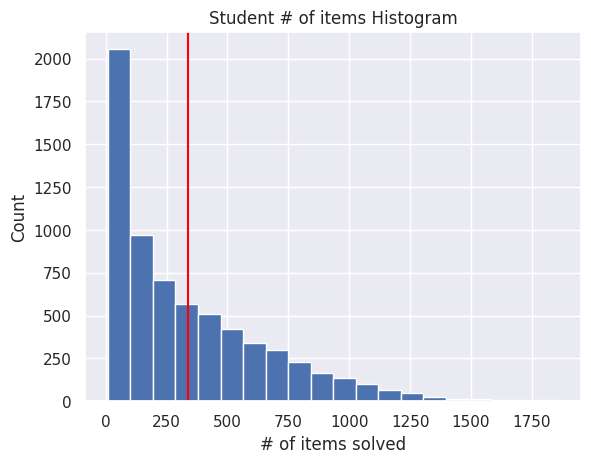

In [20]:
fig, ax = plt.subplots()

stu_groupby['assessmentItemID'].hist(bins=20, ax=ax)

ax.set_title('Student # of items Histogram')
ax.set_xlabel('# of items solved')
ax.set_ylabel('Count')
ax.axvline(stu_groupby['assessmentItemID'].mean(), color='red')
ax.grid(b=True)

#### 사용자 정답률 도수분포표

/tmp/ipykernel_38336/1795024208.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


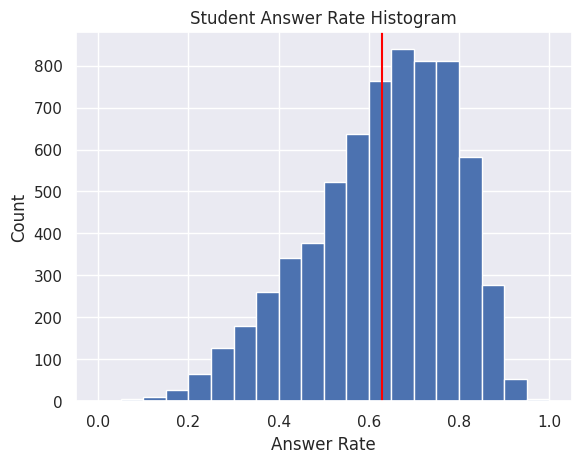

In [23]:
fig, ax = plt.subplots()

stu_groupby['answerCode'].hist(bins=20)

ax.set_title('Student Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(stu_groupby['answerCode'].mean(), color='red')
ax.grid(b=True)

### 문항 별 정답률 분석

In [24]:
prob_groupby = df.groupby('assessmentItemID').agg({
    'userID': 'count',
    'answerCode': percentile
})
prob_groupby.describe()

,userID,answerCode
count,9454.000000,9454.000000
mean,239.748889,0.654256
std,71.893791,0.195488
min,43.000000,0.049430
25%,220.000000,0.505548
50%,230.000000,0.666667
75%,271.000000,0.820513
max,454.000000,0.996310


/tmp/ipykernel_38336/833152311.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


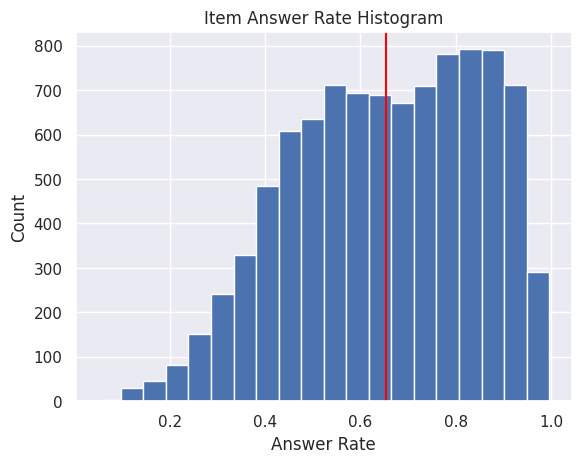

In [25]:
fig, ax = plt.subplots()
prob_groupby['answerCode'].hist(bins=20)
ax.set_title('Item Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(prob_groupby['answerCode'].mean(), color='red')
ax.grid(b=True)

### 시험지 별 정답률 분석

In [25]:
test_groupby = df.groupby('testId').agg({
    'userID': 'count',
    'answerCode': percentile
})
test_groupby.describe()

,userID,answerCode
count,1537.000000,1537.000000
mean,1474.681848,0.667982
std,533.526783,0.138903
min,172.000000,0.327186
25%,1320.000000,0.561819
50%,1400.000000,0.680519
75%,1602.000000,0.778439
max,3960.000000,0.955474


/tmp/ipykernel_25973/4199184374.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


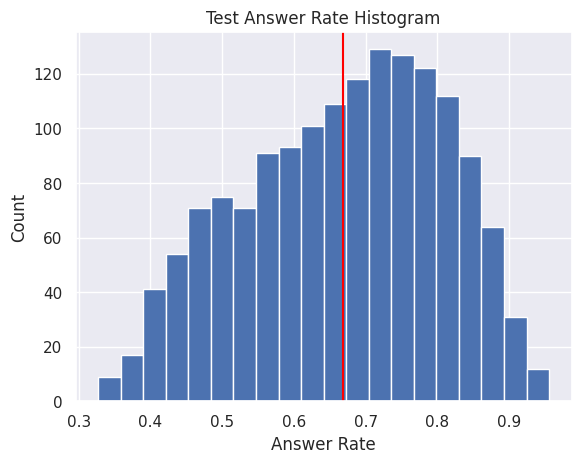

In [26]:
fig, ax = plt.subplots()
test_groupby['answerCode'].hist(bins=20)
ax.set_title('Test Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(test_groupby['answerCode'].mean(), color='red')
ax.grid(b=True)

## 1.3 일반적인 EDA

### 문항을 더 많이 푼 학생이 문제를 더 맞추는가?
분포도 위에 전반적인 동향을 살피고 싶을 때 `seaborn` 라이브러리의 `lmplot`을 사용하면 좋습니다.

Text(0.5, 1.0, '# of Questions - Answer Rate')

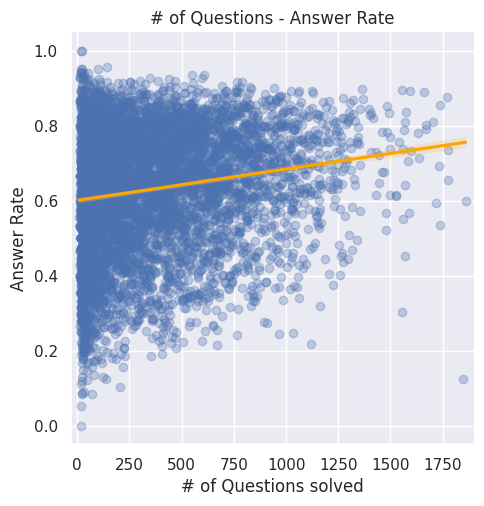

In [46]:
g = sns.lmplot(
    data=stu_groupby,
    x='assessmentItemID',
    y='answerCode',
    scatter_kws={'alpha':0.3},
    line_kws={"color": "orange"}
)
g.set_xlabels('# of Questions solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 1900))

ax = plt.gca()
ax.set_title('# of Questions - Answer Rate')

In [28]:
# 상관관계는 특성 간 인과를 알려주지 않지만 어느 정도 살펴보기는 해야하는 지표입니다.
print(f"정답률과 문제를 푼 개수 사이 인과관계: {stu_groupby.corr()['assessmentItemID']['answerCode']:.3f}")

정답률과 문제를 푼 개수 사이 인과관계: 0.168


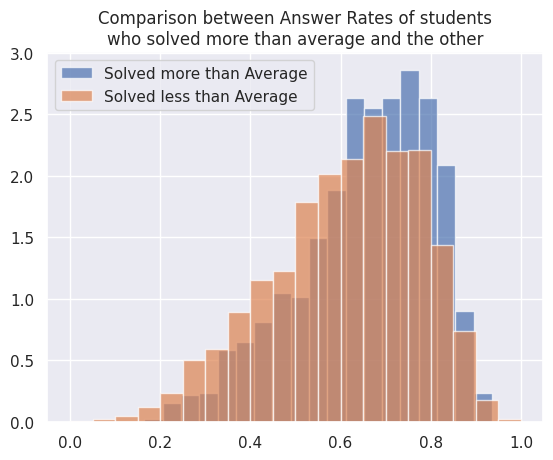

In [48]:
fig, ax = plt.subplots()

ax.set_title('Comparison between Answer Rates of students\nwho solved more than average and the other')
stu_num_mean = stu_groupby['assessmentItemID'].mean()
stu_groupby[stu_groupby['assessmentItemID'] >= stu_num_mean]['answerCode'].hist(
    bins=20, ax=ax, alpha=0.7, stacked=True, density=1, label='Solved more than Average'
)
stu_groupby[stu_groupby['assessmentItemID'] < stu_num_mean]['answerCode'].hist(
    bins=20, ax=ax, alpha=0.7, stacked=True, density=1, label='Solved less than Average'
)
ax.legend()

### 더 많이 노출된 태그가 정답률이 더 높은가?

In [30]:
tag_groupby = df.groupby('KnowledgeTag').agg({
    'userID': 'count',
    'answerCode': percentile
})
tag_groupby.describe()

,userID,answerCode
count,912.000000,912.000000
mean,2485.291667,0.615524
std,1732.086925,0.148329
min,44.000000,0.188940
25%,1025.250000,0.498239
50%,2204.000000,0.599585
75%,4052.750000,0.740288
max,12892.000000,0.977778


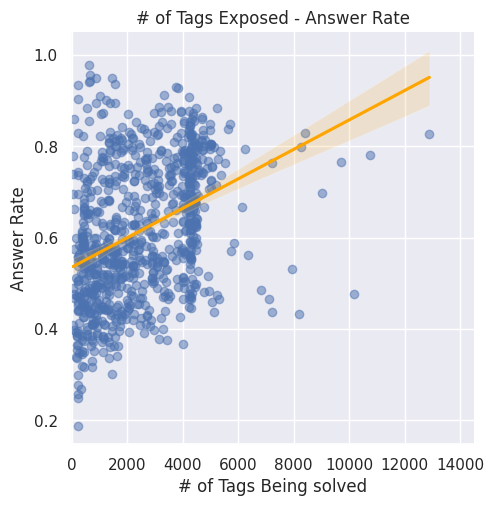

In [31]:
g = sns.lmplot(
    data=tag_groupby,
    x='userID',
    y='answerCode',
    scatter_kws={'alpha':0.5},
    line_kws={"color": "orange"}
)
g.set_xlabels('# of Tags Being solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 14500))

ax = plt.gca()
ax.set_title('# of Tags Exposed - Answer Rate');

In [32]:
tag_groupby

,userID,answerCode
KnowledgeTag,,
23,1800,0.584444
24,358,0.614525
25,92,0.858696
26,2432,0.614309
30,539,0.536178
...,...,...
11253,4282,0.739374
11265,454,0.676211
11269,2417,0.557716


In [33]:
print(f"태그를 풀었던 사용자의 수와 정답률 사이 상관관계: {tag_groupby.corr()['answerCode']['userID']:.3f}")

태그를 풀었던 사용자의 수와 정답률 사이 상관관계: 0.376


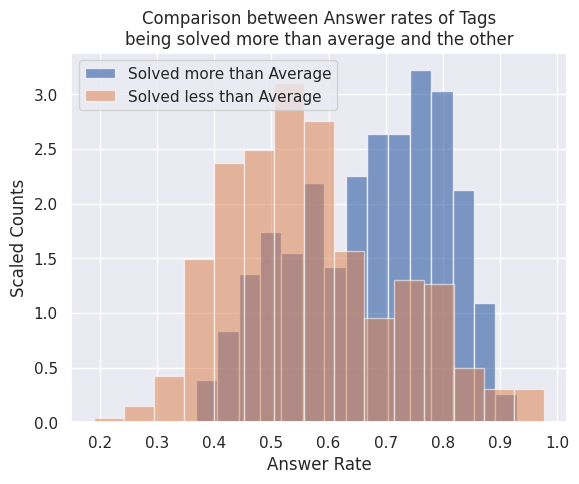

In [34]:
fig, ax = plt.subplots()

tag_ans_mean = tag_groupby['userID'].mean()
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Scaled Counts')
ax.set_title('Comparison between Answer rates of Tags\nbeing solved more than average and the other')

tag_groupby[tag_groupby['userID'] >= tag_ans_mean]['answerCode'].hist(
    ax=ax, alpha=0.7, bins=15, density=1, stacked=True, label='Solved more than Average'
)
tag_groupby[tag_groupby['userID'] < tag_ans_mean]['answerCode'].hist(
    ax=ax, alpha=0.55, bins=15, density=1, stacked=True, label='Solved less than Average'
)
ax.legend()

### 문항을 풀수록 실력이 늘어나는가?

In [35]:
# 누적합
_cumsum = df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumsum'})
# 누적갯수
_cumcount = df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumcount'}) + 1

cum_ans = _cumsum / _cumcount
cum_ans['userID'] = df['userID']
window_sizes = [30, 70, 100, 120]

푼 문항의 갯수가 중앙값 부근인 10명의 학생들

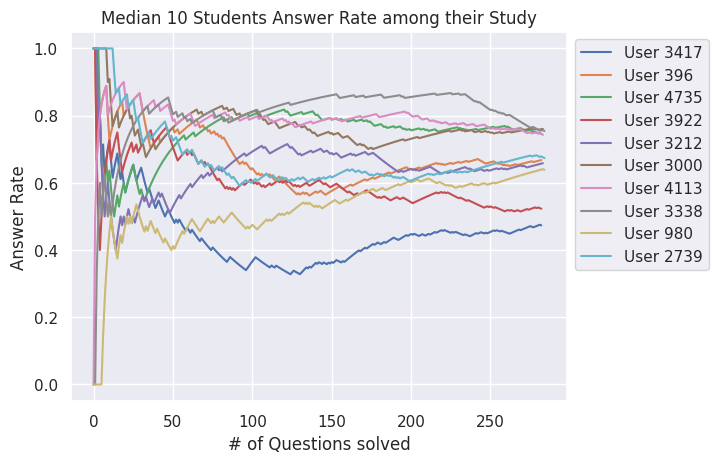

In [36]:
fig, ax = plt.subplots()
ax.set_title('Median 10 Students Answer Rate among their Study')
ax.set_xlabel('# of Questions solved')
ax.set_ylabel('Answer Rate')

samples = df.groupby('userID').agg({'assessmentItemID': 'count'}).sort_values(by='assessmentItemID').index[7442//2-5:7442//2+5]
for idx in samples:
    cum_ans[cum_ans['userID'] == idx]['answerCode'].reset_index(drop=True).plot(ax=ax, label=f'User {idx}')
ax.legend(bbox_to_anchor=(1, 1))

정답률이 중앙값 부근인 10명의 학생들

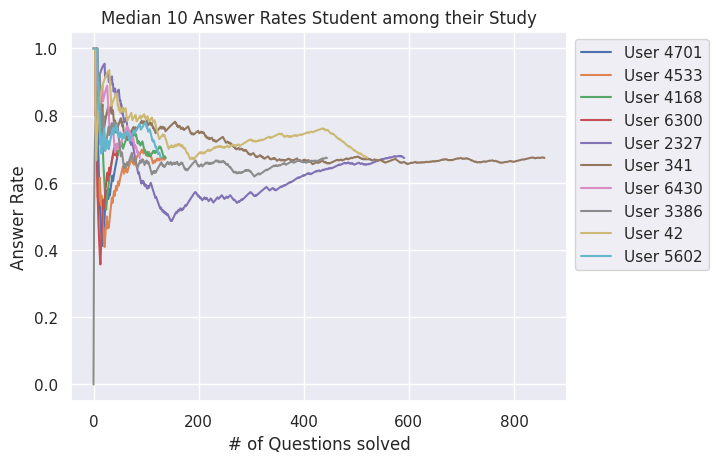

In [37]:
fig, ax = plt.subplots()
ax.set_title('Median 10 Answer Rates Student among their Study')
ax.set_xlabel('# of Questions solved')
ax.set_ylabel('Answer Rate')

samples = df.groupby('userID').agg({'answerCode': percentile}).sort_values(by='answerCode').index[7442//2-5:7442//2+5]
for idx in samples:
    cum_ans[cum_ans['userID'] == idx]['answerCode'].reset_index(drop=True).plot(ax=ax, label=f'User {idx}')
ax.legend(bbox_to_anchor=(1, 1))

Window_size 적용

In [38]:
def plot_rolled_answerrate(userID, ax, window_sizes=[70, 100, 120]):
    
    ax.set_title(f'Students Answer Rate among their Study - User {userID}')
    ax.set_xlabel('# of Questions solved')
    ax.set_ylabel('Answer Rate')

    cum_ans[cum_ans['userID'] == userID]['answerCode'].reset_index(drop=True).plot(
        ax=ax, label=f'Without Window', linewidth=3)

    for wdw_sz in window_sizes:    
        (df[df.userID == userID]['answerCode'].rolling(wdw_sz).sum().reset_index(drop=True) / wdw_sz).plot(
            ax=ax, label=f'Window size {wdw_sz}', alpha=0.8)

    ax.legend()

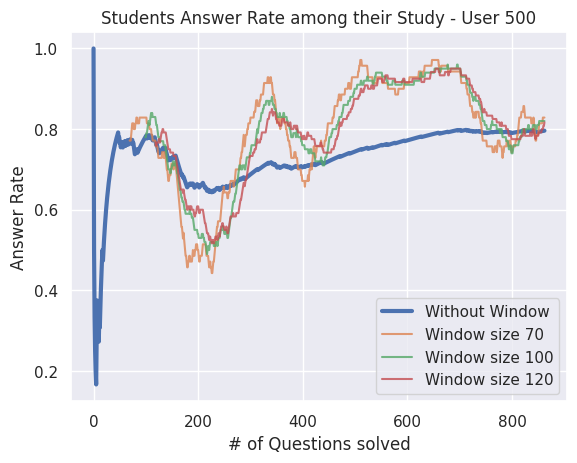

In [39]:
fig, ax = plt.subplots()
plot_rolled_answerrate(500, ax)

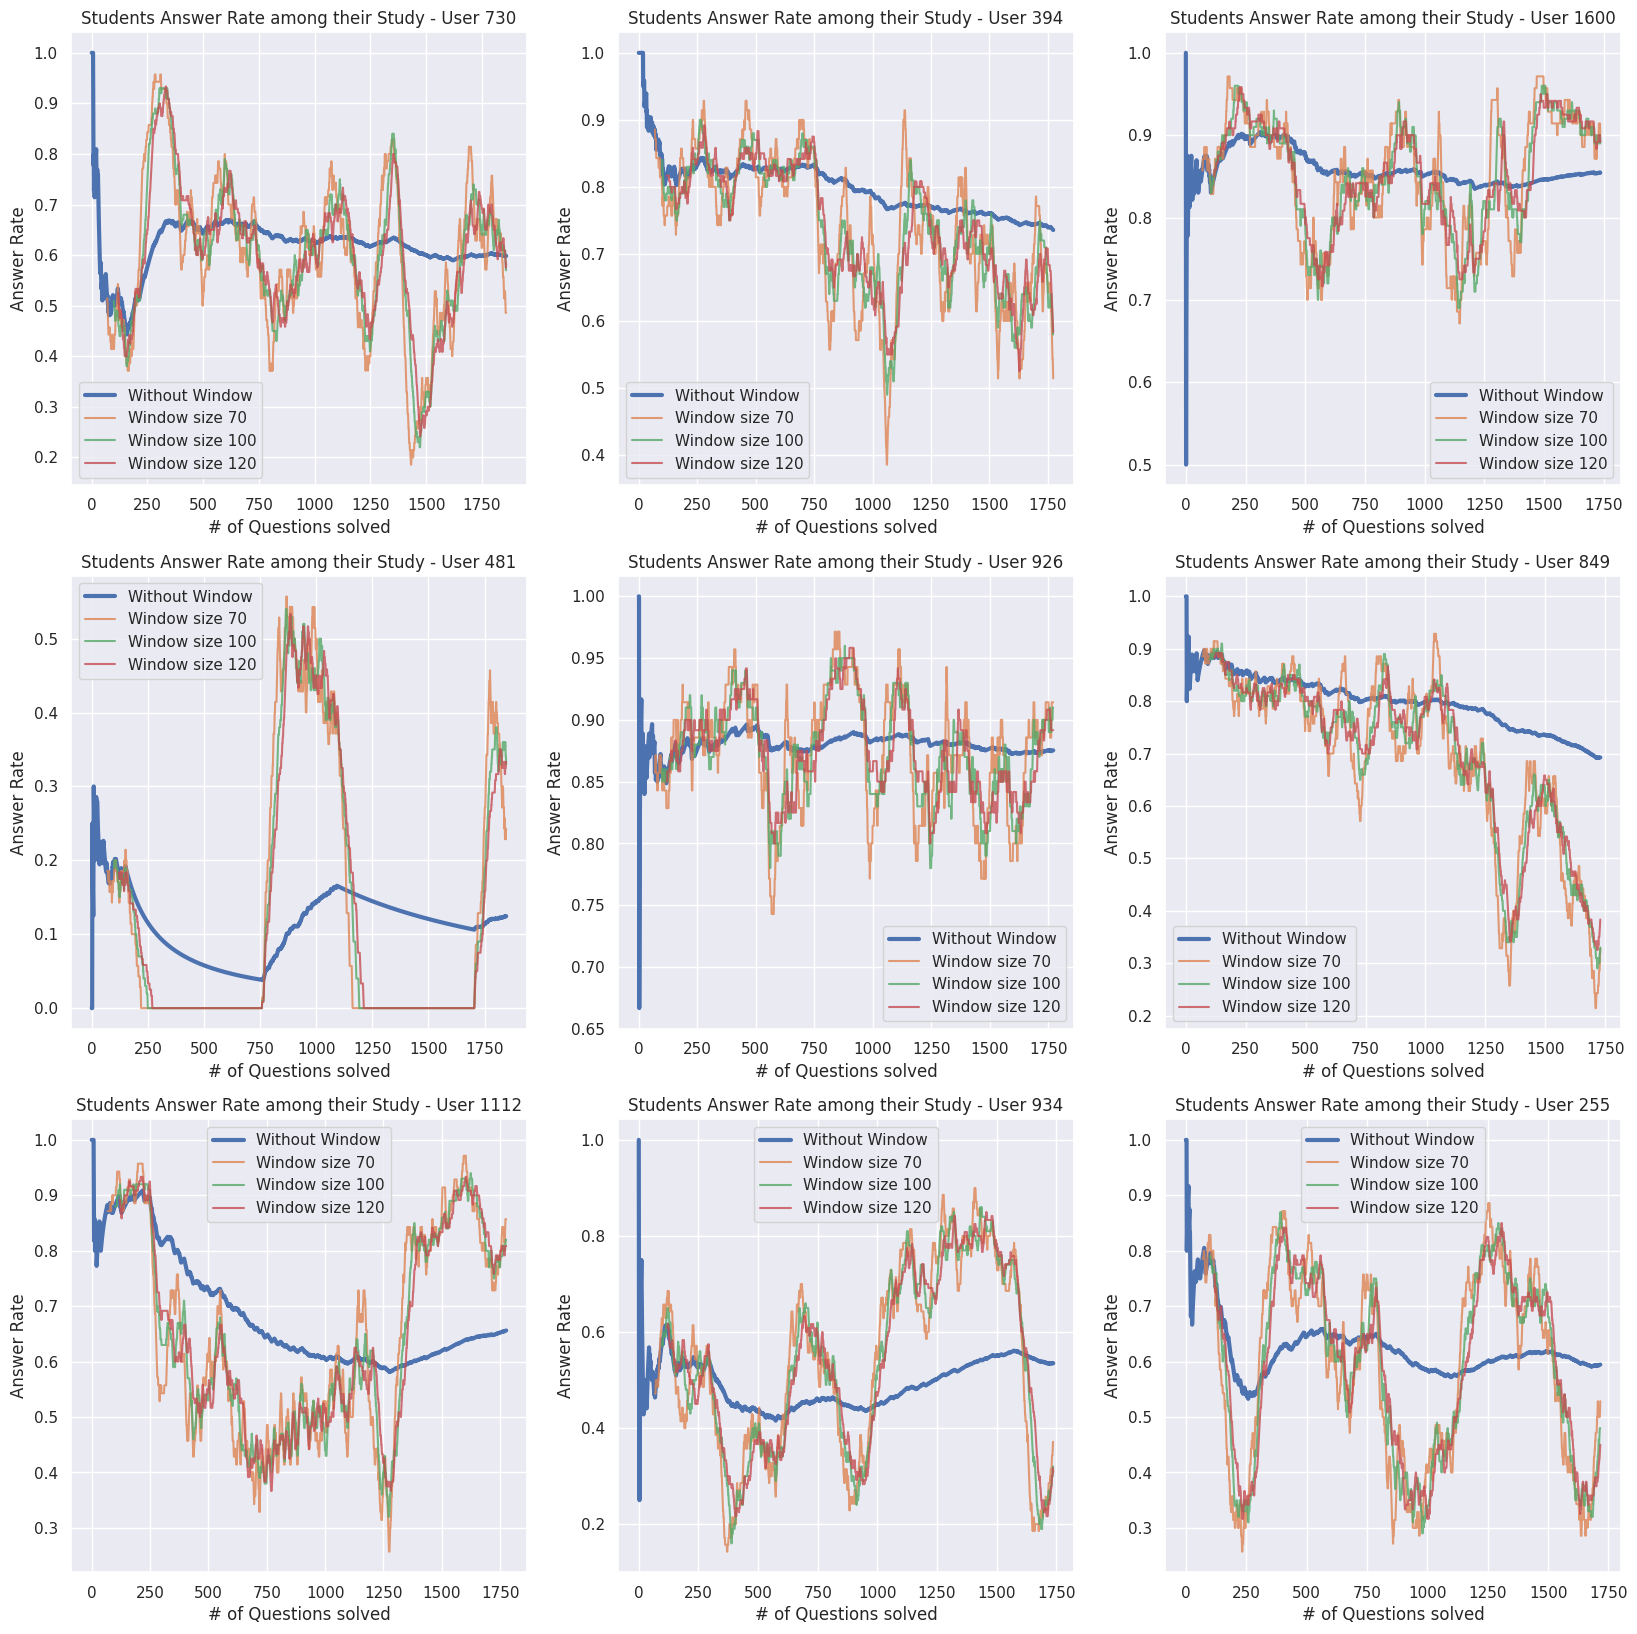

In [40]:
idx = df.groupby('userID').agg({'answerCode': 'count'}).sort_values(by='answerCode', ascending=False).iloc[:9].index
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
plt.title('Top 9 Students who solved the most problems')
for i, userID in enumerate(idx):
    
    r, c = i%3, i//3
    plot_rolled_answerrate(userID, axes[r, c])

### 문항을 푸는 데 걸린 시간과 정답률 사이의 관계는?

In [41]:
diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
diff = diff.fillna(pd.Timedelta(seconds=0))
diff = diff['Timestamp'].apply(lambda x: x.total_seconds())

df['elapsed'] = diff

elapsed_answer = df.groupby('elapsed').agg({'answerCode': percentile, 'userID': 'count'})
elapsed_hist = elapsed_answer[elapsed_answer['userID'] > 100]

(-10.0, 650.0)

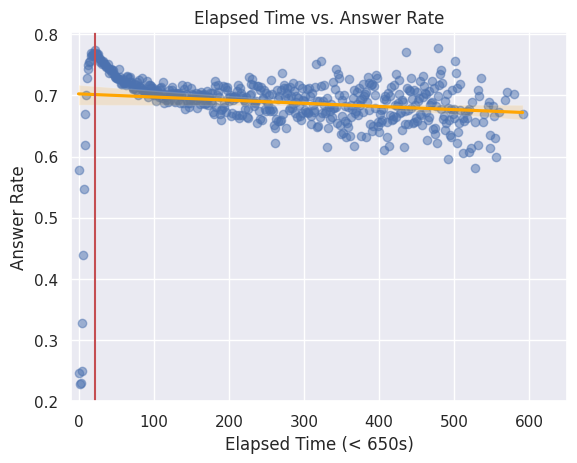

In [42]:
fig, ax = plt.subplots()
g = sns.regplot(x=elapsed_hist.index[:-1], y=elapsed_hist.answerCode.values[:-1],
            scatter_kws={'alpha':0.5}, line_kws={"color": "orange"}, ax=ax)
ax.set_title('Elapsed Time vs. Answer Rate')
ax.set_xlabel('Elapsed Time (< 650s)')
ax.set_ylabel('Answer Rate')
ax.axvline(22, color='r')
ax.set_xlim(-10, 650)

# 2. Daily Mission

### (a)
사실 위에서 그린 문항수-정답률 그래프는 큰 insight를 주지 못하는 것 같습니다. 같은 문항을 푼 학생들의 정답률은 당연히 상이하겠지만, 이 평균을 보는 것이 더 의미가 있을 것 같은데 아래처럼 보면 너무 점이 많아서 insight를 얻기 힘드네요.
![image.png](attachment:image.png)

그러면 이번엔 같은 문항수를 푼 학생들이 있다면, 그 학생들의 평균을 찍어서 그래프를 그려봅시다. 가령 9문항을 푼 학생이 10명이라면, 그 학생들의 평균이 찍히도록 말이죠! 아래와 같은 형태이면 좋을 것 같습니다.
- **x-axis**: 사용자가 푼 문항의 수
- **y-axis**: 정답률   
<br>
![image.png](mission_a.png)

### (b)

그런데 위 그래프도... 사실 점이 너무 많습니다. 이것보다 더 줄이려면 단순히 같은 문항수를 푼 학생들끼리 평균을 집계하는 것이 아니라, 어느 정도 비슷한 문항을 푼 학생들을 전부 집계하면 좋을 것 같네요. 예를 들면 9 ~ 14문항을 푼 학생들을 묶어서 평균을 내는 것처럼요.   
`bins` 값을 주었을 때 bins 만큼 그래프에 점이 찍히도록, 예를 들어 bins=500이었다면 아래와 같이 500개의 bin을 만들어서 그래프가 그려지도록 해주세요 :)    

![image.png](mission_b.png)

###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.

